In [56]:
def time_based_interpolation(df, target_cols, half_life_days=30):
    df_interp = df.copy()
    
    for col in target_cols:
        df_interp[col] = pd.to_numeric(df_interp[col].replace('-', np.nan), errors='coerce')
    
    df_interp['hour'] = df_interp['Start date'].dt.hour
    df_interp['weekday'] = df_interp['Start date'].dt.dayofweek
    df_interp['month'] = df_interp['Start date'].dt.month
    df_interp['year'] = df_interp['Start date'].dt.year
    
    for col in target_cols:
        mask_missing = df_interp[col].isna()
        
        for idx in df_interp[mask_missing].index:
            current_date = df_interp.loc[idx, 'Start date']
            hour = df_interp.loc[idx, 'hour']
            weekday = df_interp.loc[idx, 'weekday']
            current_month = df_interp.loc[idx, 'month']
            
            similar_times = df_interp[
                (df_interp['hour'] == hour) &
                (df_interp['weekday'] == weekday) &
                (df_interp['Start date'] < current_date) &
                (df_interp[col].notna())
            ]
            
            if len(similar_times) > 0:
                days_diff = (current_date - similar_times['Start date']).dt.days
                weights = np.exp(-days_diff / half_life_days) ** 2
                
                weights[days_diff <= 14] *= 1.5
                
                months_diff = abs(similar_times['month'] - current_month)
                months_diff = abs(months_diff % 12)

                # same month
                weights[months_diff == 0] *= 2.0
                # adjacent month
                weights[months_diff == 1] *= 1.5
                # more than 2 away
                weights[months_diff == 2] *= 1.25
                
                weights = weights / weights.sum()
                df_interp.loc[idx, col] = (similar_times[col] * weights).sum()
    
    return df_interp

In [57]:
def plot_imputation_results(original_df, imputed_df, method_name, target_cols, gaps_dict):
    """Plot original vs imputed values for each gap"""
    
    figs = []
    
    for col in target_cols:
        # Convert data to numeric first
        original_df[col] = pd.to_numeric(original_df[col].replace('-', np.nan), errors='coerce')
        
        for gap_start, gap_end in gaps_dict[col]:
            # Convert dates to datetime
            vis_start = pd.to_datetime(gap_start) - pd.Timedelta(days=5)
            vis_end = pd.to_datetime(gap_end) + pd.Timedelta(days=5)
            
            mask = (original_df['Start date'] >= vis_start) & \
                   (original_df['Start date'] <= vis_end)
            
            # Skip if no data in visualization window
            if not any(mask):
                print(f"Skipping {col} gap {gap_start} to {gap_end} - No data in visualization window")
                continue
            
            fig, ax = plt.subplots(figsize=(15, 6))
            
            dates = original_df[mask]['Start date']
            original_data = original_df[mask][col]
            not_missing = ~original_data.isna()
            
            # Plot original data
            mask_diff = not_missing.astype(int).diff()
            break_points = mask_diff.ne(0).cumsum()
            
            for segment in break_points.unique():
                segment_mask = break_points == segment
                if not_missing[segment_mask].any():
                    ax.plot(dates[segment_mask], 
                           original_data[segment_mask],
                           'b-o', label='Original' if segment == break_points.iloc[0] else "", 
                           alpha=0.7)
            
            # Plot imputed values
            gap_start_dt = pd.to_datetime(gap_start)
            gap_end_dt = pd.to_datetime(gap_end)
            
            imputation_period = (dates >= gap_start_dt) & (dates <= gap_end_dt)
            
            # Find previous and next values if they exist
            prev_dates = dates[dates < gap_start_dt]
            next_dates = dates[dates > gap_end_dt]
            
            imputed_dates = dates[imputation_period]
            imputed_values = imputed_df.loc[imputation_period.index[imputation_period], col]
            
            # Add connecting points if they exist
            if len(prev_dates) > 0:
                prev_value_date = prev_dates.iloc[-1]
                prev_value = original_df.loc[original_df['Start date'] == prev_value_date, col].iloc[0]
                imputed_dates = pd.concat([pd.Series([prev_value_date]), imputed_dates])
                imputed_values = pd.concat([pd.Series([prev_value]), imputed_values])
            
            if len(next_dates) > 0:
                next_value_date = next_dates.iloc[0]
                next_value = original_df.loc[original_df['Start date'] == next_value_date, col].iloc[0]
                imputed_dates = pd.concat([imputed_dates, pd.Series([next_value_date])])
                imputed_values = pd.concat([imputed_values, pd.Series([next_value])])
            
            ax.plot(imputed_dates, imputed_values,
                   'r-o', label='Imputed Values', alpha=0.7)
            
            ax.set_title(f'{col} - {method_name}\nGap: {gap_start} to {gap_end}')
            ax.set_xlabel('Date')
            ax.set_ylabel('Price [€/MWh]')
            ax.legend()
            ax.grid(True)
            ax.tick_params(axis='x', rotation=45)
            
            plt.tight_layout()
            figs.append(fig)
    
    return figs

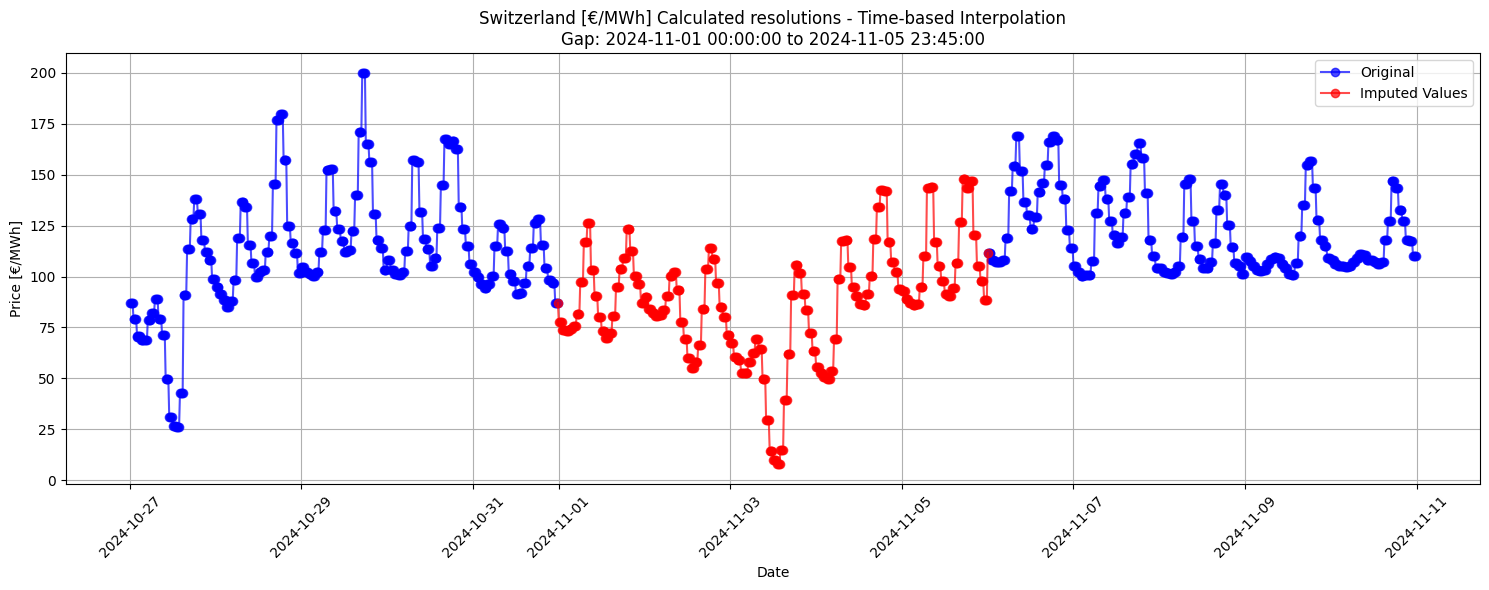

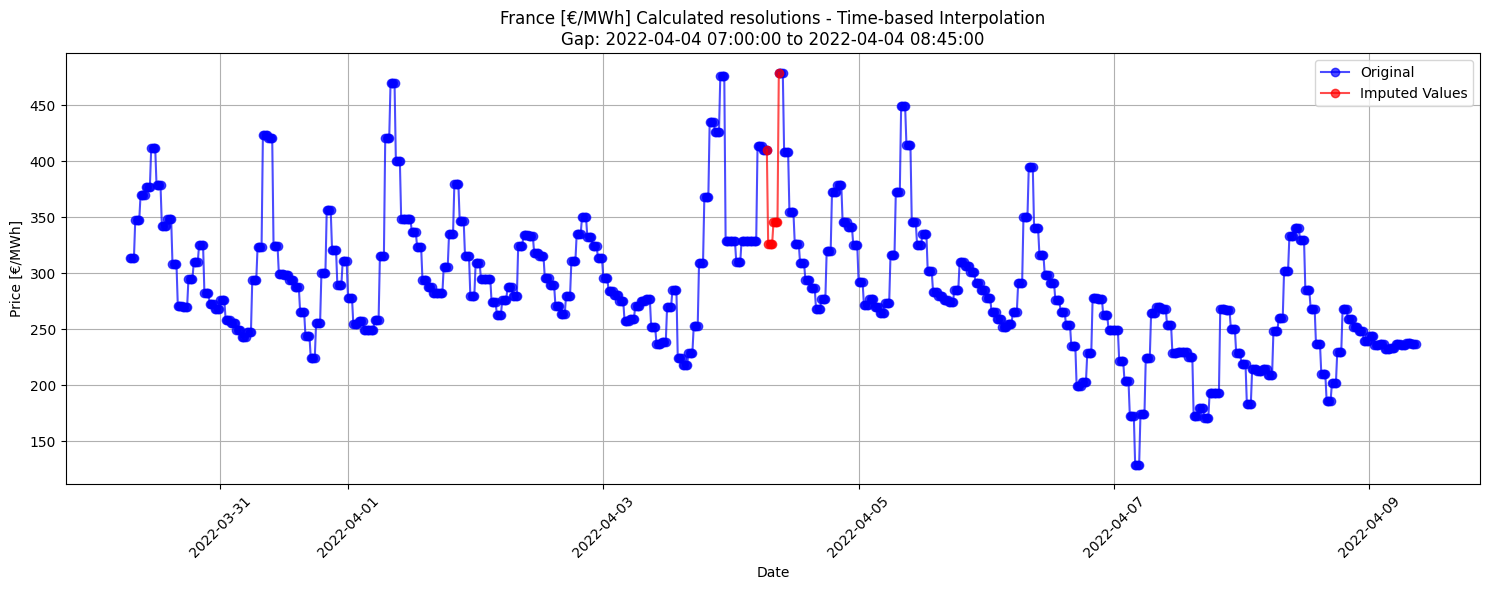

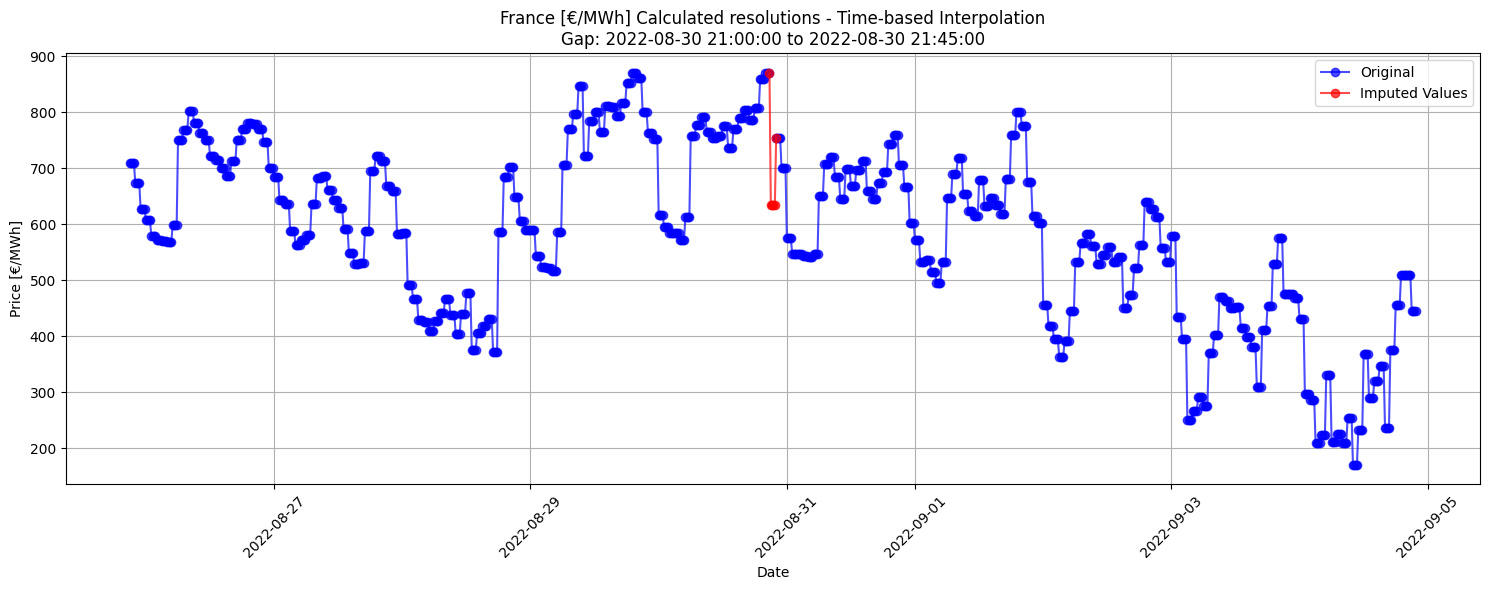

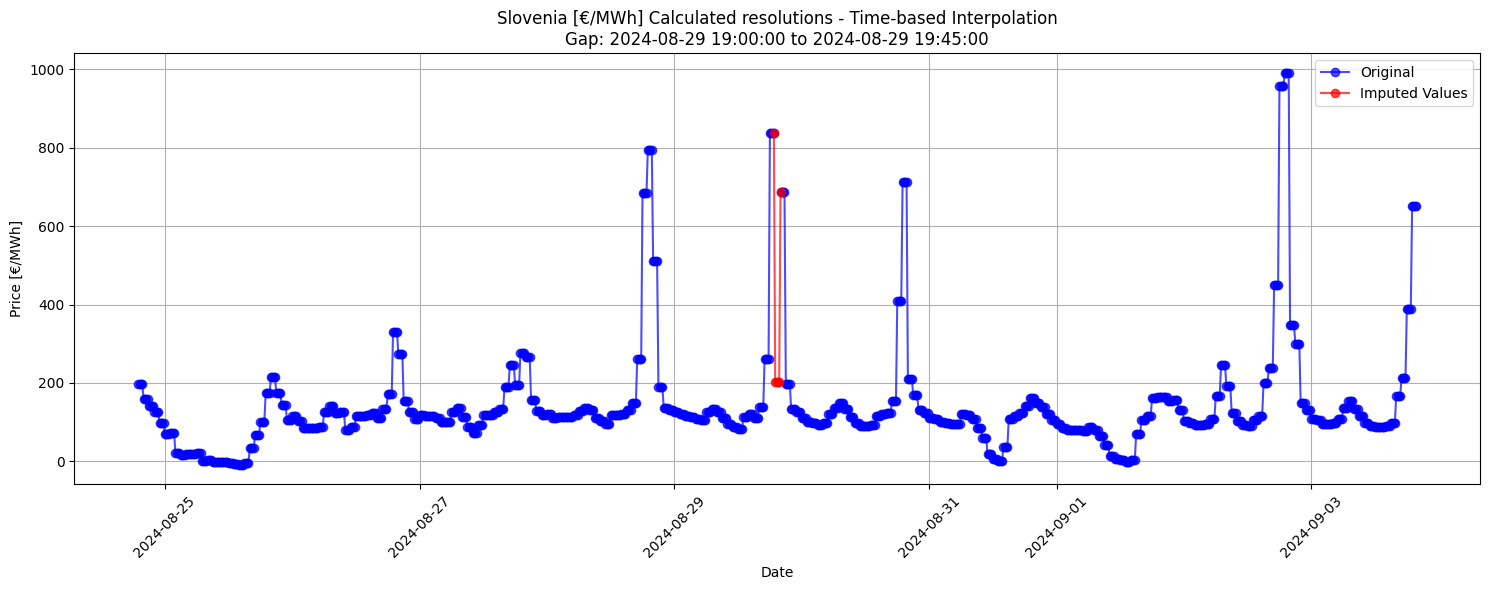

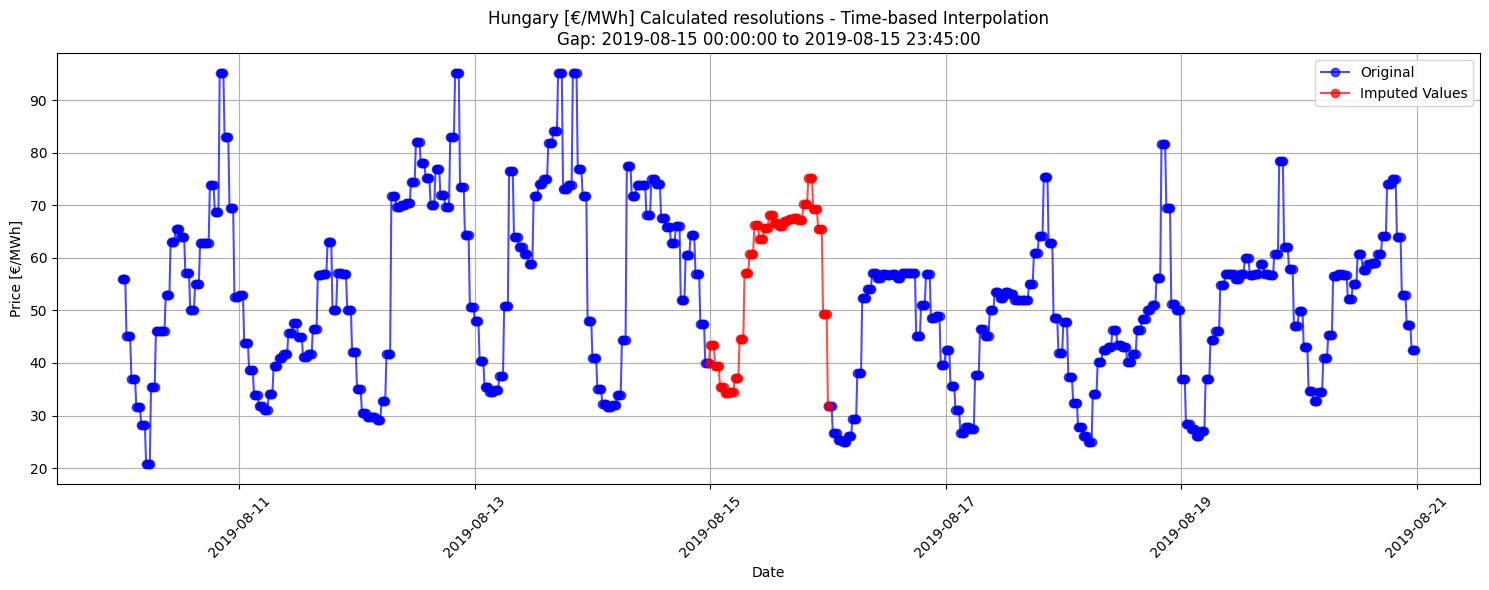

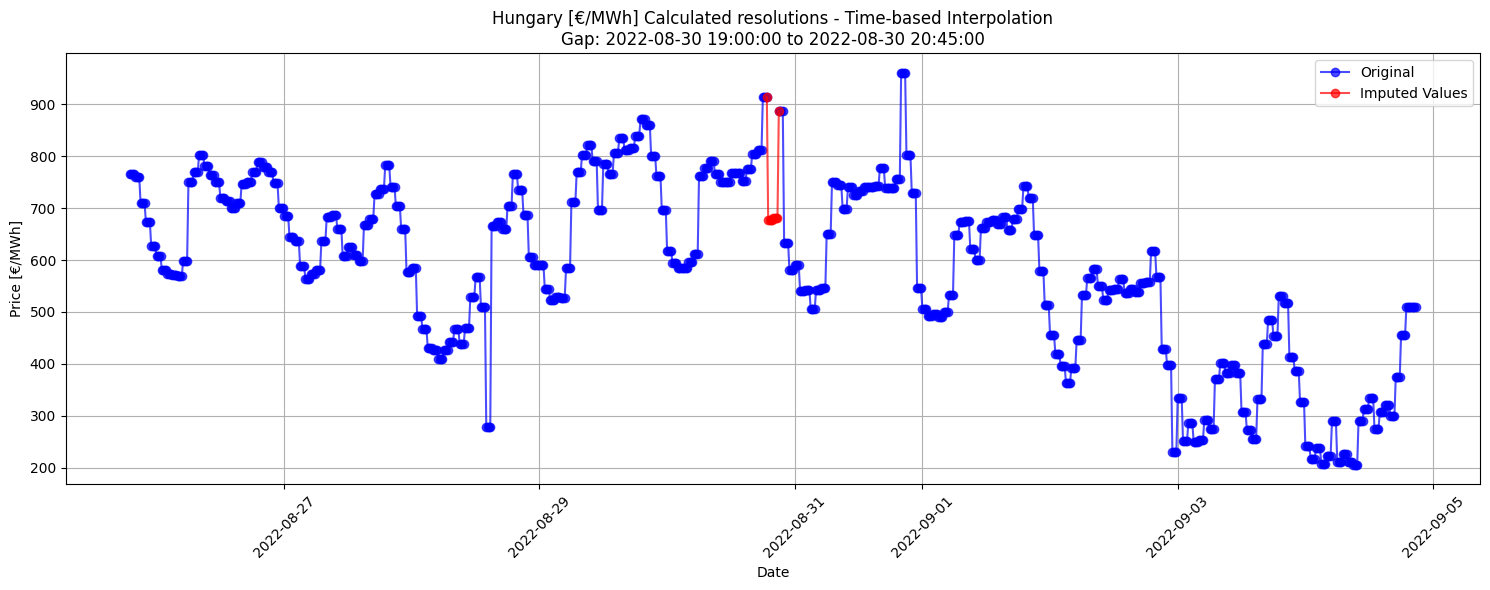

In [58]:
if __name__ == "__main__":
    # Define gaps for all countries
    gaps_dict = {
        'Switzerland [€/MWh] Calculated resolutions': [
            ('2024-11-01 00:00:00', '2024-11-05 23:45:00')
        ],
        'France [€/MWh] Calculated resolutions': [
            ('2022-04-04 07:00:00', '2022-04-04 08:45:00'),
            ('2022-08-30 21:00:00', '2022-08-30 21:45:00')
        ],
        'Slovenia [€/MWh] Calculated resolutions': [
            ('2024-08-29 19:00:00', '2024-08-29 19:45:00')
        ],
        'Hungary [€/MWh] Calculated resolutions': [
            ('2019-08-15 00:00:00', '2019-08-15 23:45:00'),
            ('2022-08-30 19:00:00', '2022-08-30 20:45:00')
        ]
    }

    # Load data
    df = pd.read_csv('smard1_filtered.csv', delimiter=';', low_memory=False)
    df['Start date'] = pd.to_datetime(df['Start date'], format='mixed')

    # Apply time-based interpolation
    df_time = time_based_interpolation(df, list(gaps_dict.keys()))

    # Save imputed data
    #df_time.to_csv('smard_time_based_interpolation.csv', sep=';', index=False)
    #print("Imputed data saved to 'smard_time_based_interpolation.csv'")

    # Plot results
    figs = plot_imputation_results(df, df_time, "Time-based Interpolation", list(gaps_dict.keys()), gaps_dict)
    plt.show()